# 20240202_Open_Source_Example_Notebook_with_Results_and_Plots

    Project: JMR23 - Disentangling Watches
    Author: Alex Burnap
    Email: alex.burnap@yale.edu
    Date: Feb. 2, 2024
    License: MIT

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_388560/1752212046.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import math
import glob
import numpy
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
az.rcParams["plot.max_subplots"] = 100

In [3]:
RANDOM_SEED = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(RANDOM_SEED)

In [4]:
from data import get_data
from run_HB_conjoint import run_HB_conjoint_model

/home/pangaea-gaia/anaconda3/envs/pymc/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


# Globals

In [5]:
NUM_RESPONDENTS = 253
NUM_ALTERNATIVES = 2
NUM_ATTRIBUTES = 6
NUM_TASKS = 15
NUM_TRAIN_TASKS = 13
NUM_TEST_TASKS = 2
NUM_COVARIATES = 6

np.random.seed(RANDOM_SEED)

In [6]:
COVARIATE_NAMES = ["DemoGender_male",
                    "DemoGender_female",
                    "DemoAge_real",
                    "DemoIncome_real",
                    "DemoEducation_real",
                    "DemoAestheticImportance1_1_real"]

VISUAL_ATTRIBUTE_NAMES =  ["dialcolor",
                         "dialshape",
                         "strapcolor",
                         "dialsize",
                         "knobsize",
                         "rimcolor"]

# Get Data

In [7]:
# Create random Train/Valid/Test Indices
TRAIN_TASK_INDICES = np.sort(np.random.choice(range(NUM_TASKS), NUM_TRAIN_TASKS, replace=False))
TEST_TASK_INDICES = np.setdiff1d(range(NUM_TASKS), TRAIN_TASK_INDICES)

In [8]:
X_train, X_test, Y_train, Y_test, Z_df = get_data(TRAIN_TASK_INDICES, TEST_TASK_INDICES)

In [9]:
# Sanity check, should be ((253, 13, 2, 6), (253, 13), (253, 6))
X_train.shape, Y_train.shape, Z_df.shape

((253, 13, 2, 6), (253, 13), (253, 6))

# Benchmark - Aggregate Logit

In [10]:
X_pairwise_train = X_train[:,:,1,:] - X_train[:,:,0,:]
X_pairwise_train = X_pairwise_train.reshape(253*NUM_TRAIN_TASKS, 6)
X_pairwise_train_df = pd.DataFrame(X_pairwise_train, columns=VISUAL_ATTRIBUTE_NAMES)

Y_train_raveled = Y_train.reshape(253*NUM_TRAIN_TASKS, 1)
X_pairwise_train_df["Response"] = Y_train_raveled

In [11]:
aggregate_logit_model = smf.logit('Response ~ dialcolor + dialshape + strapcolor + dialsize + knobsize + rimcolor',
                                  data=X_pairwise_train_df).fit(method = "newton",
                                                                maxiter=35,
                                                                disp=True)
print(aggregate_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.626525
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 3289
Model:                          Logit   Df Residuals:                     3282
Method:                           MLE   Df Model:                            6
Date:                Fri, 02 Feb 2024   Pseudo R-squ.:                 0.09266
Time:                        22:25:08   Log-Likelihood:                -2060.6
converged:                       True   LL-Null:                       -2271.1
Covariance Type:            nonrobust   LLR p-value:                 9.150e-88
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1000      0.038     -2.654      0.008      -0.174      -0.026
dialcolor      0.0976      0.

## In-Sample Logit Results

In [12]:
y_hat_logit_train = aggregate_logit_model.predict(X_pairwise_train_df)
y_hat_logit_train_binary_preds = (np.array(y_hat_logit_train)>0.5)*1
np.average(np.array(y_hat_logit_train_binary_preds == X_pairwise_train_df["Response"])*1.0)

0.6640316205533597

## Out of Sample Logit Results

In [13]:
X_pairwise_test = X_test[:,:,1,:] - X_test[:,:,0,:]
X_pairwise_test = X_pairwise_test.reshape(253*NUM_TEST_TASKS, 6)
X_pairwise_test_df = pd.DataFrame(X_pairwise_test, columns=VISUAL_ATTRIBUTE_NAMES)
Y_test_raveled = Y_test.reshape(253*NUM_TEST_TASKS)

In [14]:
y_hat_test = aggregate_logit_model.predict(X_pairwise_test_df)
y_hat_test_binary_preds = (np.array(y_hat_test)>0.5)*1
np.average(np.array(y_hat_test_binary_preds == Y_test_raveled)*1.0)

0.6027667984189723

In [15]:
# Seed 0, 1, 2
aggregate_logit_prediction_accuracy = np.array([0.6166, 0.6027, 0.6699])
aggregate_logit_prediction_accuracy.mean(), aggregate_logit_prediction_accuracy.std()

(0.6297333333333334, 0.028963463574341777)

# Train HB Conjoint Model

In [16]:
HB_ind_seg_model, idata_seg = run_HB_conjoint_model(X_train=X_train,
                                                   Y_train=Y_train,
                                                   Z_df=Z_df,
                                                   mu_theta_hyper_std=0.25,
                                                   theta_std=0.25,
                                                   beta_covar_dist=0.5,
                                                   beta_covar_eta=4.0,
                                                   num_draws=2000,
                                                   num_tune=2000,
                                                   num_chains=1, # num of GPUs is most efficient for RAM -> VRAM
                                                   target_accept=0.65,
                                                   random_seed=0
                                                   )

Using PyMC version: 5.0.2. Please ensure ver >= 5 for GPU support with Jax/Numpyro
Using gpu for MCMC sampling
Sampling Devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
Note: No progress bar if > 1 GPU


/home/pangaea-gaia/anaconda3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:01.380903
Sampling...


sample: 100%|█| 4000/4000 [03:47<00:00, 17.60it/s, 63 steps of size 1.07e-01. ac


Sampling time =  0:03:59.861704
Transforming variables...
Transformation time =  0:00:01.613144


# Trace Diagnostics

In [17]:
# Jan 9, 2024 Run (original paper results run - replicated  Feb. 2, 2024)
HB_ind_seg_model

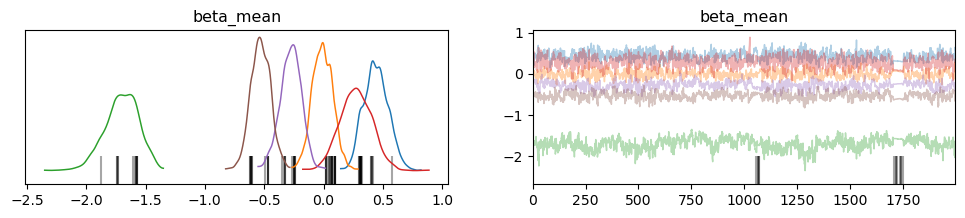

In [18]:
# Jan 9, 2024 Run (original paper results run - replicated  Feb. 2, 2024)
az.plot_trace(idata_seg, var_names=["beta_mean"]);

# Raw Full Posteriors Plotting

array([[<Axes: title={'center': 'beta_mean\n0'}>,
        <Axes: title={'center': 'beta_mean\n1'}>,
        <Axes: title={'center': 'beta_mean\n2'}>],
       [<Axes: title={'center': 'beta_mean\n3'}>,
        <Axes: title={'center': 'beta_mean\n4'}>,
        <Axes: title={'center': 'beta_mean\n5'}>]], dtype=object)

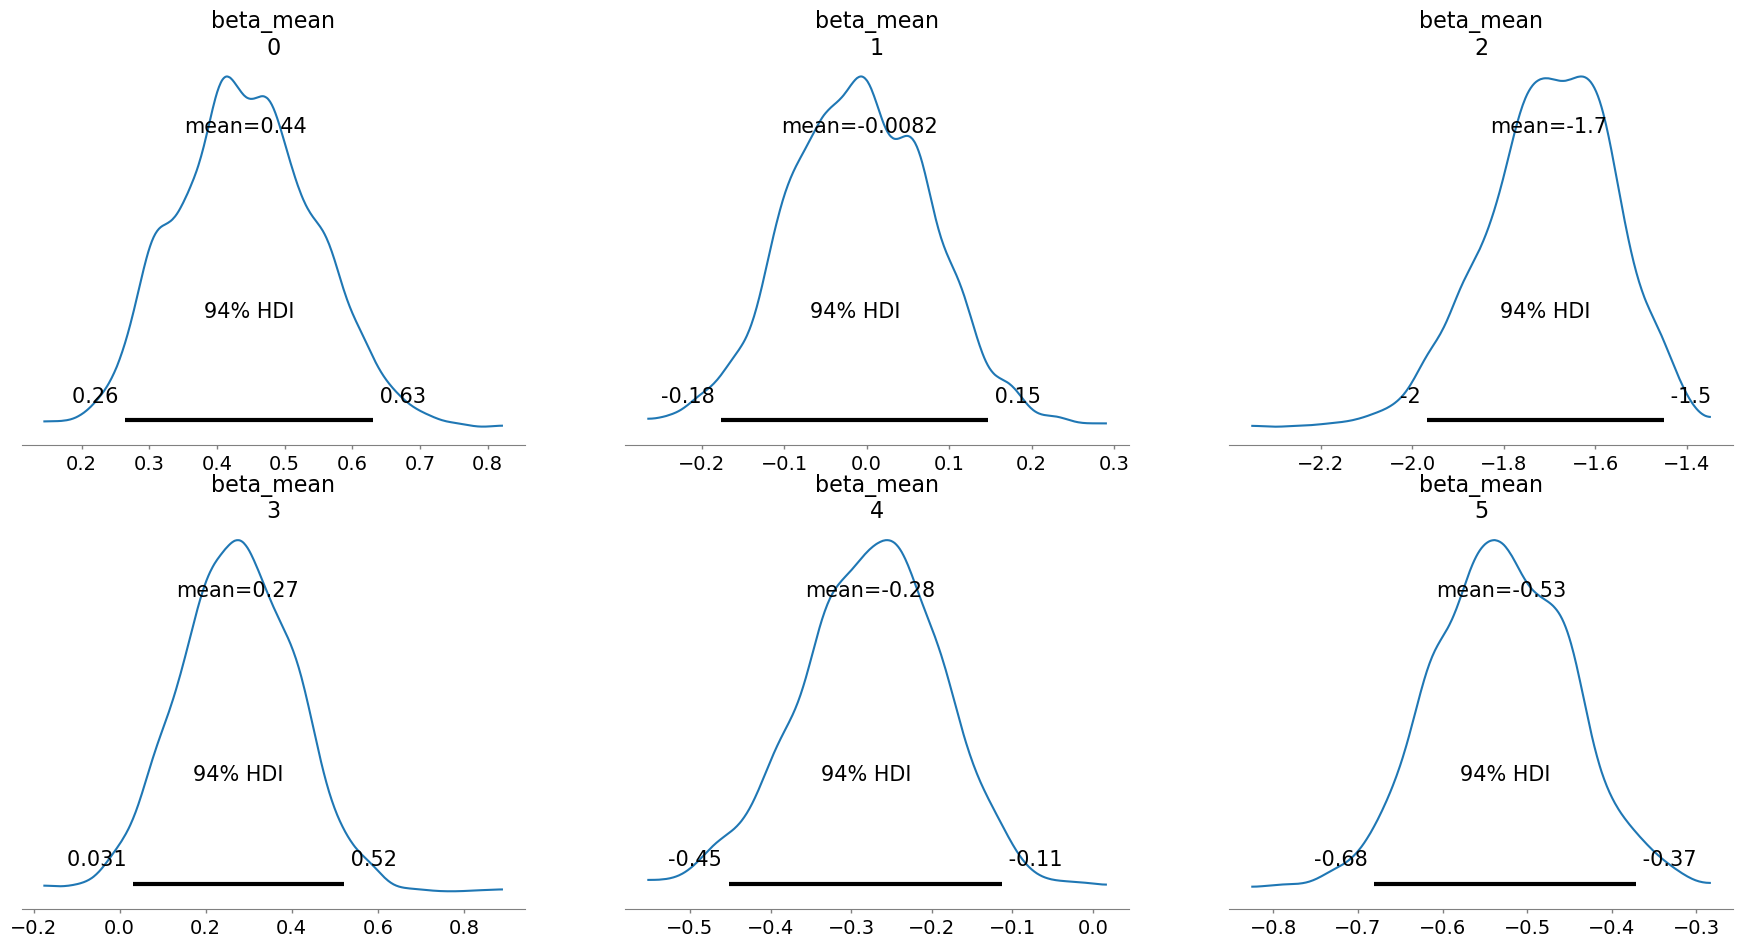

In [19]:
# Jan 9, 2024 Run (original final results run -- best Bayesian hyperparams/model setting for data)
pm.plot_posterior(idata_seg, var_names=["beta_mean"])

array([[<Axes: title={'center': 'thetas\ndialcolor, DemoGender_male'}>,
        <Axes: title={'center': 'thetas\ndialcolor, DemoGender_female'}>,
        <Axes: title={'center': 'thetas\ndialcolor, DemoAge_real'}>,
        <Axes: title={'center': 'thetas\ndialcolor, DemoIncome_real'}>],
       [<Axes: title={'center': 'thetas\ndialcolor, DemoEducation_real'}>,
        <Axes: title={'center': 'thetas\ndialcolor, DemoAestheticImportance1_1_real'}>,
        <Axes: title={'center': 'thetas\ndialshape, DemoGender_male'}>,
        <Axes: title={'center': 'thetas\ndialshape, DemoGender_female'}>],
       [<Axes: title={'center': 'thetas\ndialshape, DemoAge_real'}>,
        <Axes: title={'center': 'thetas\ndialshape, DemoIncome_real'}>,
        <Axes: title={'center': 'thetas\ndialshape, DemoEducation_real'}>,
        <Axes: title={'center': 'thetas\ndialshape, DemoAestheticImportance1_1_real'}>],
       [<Axes: title={'center': 'thetas\nstrapcolor, DemoGender_male'}>,
        <Axes: title={'c

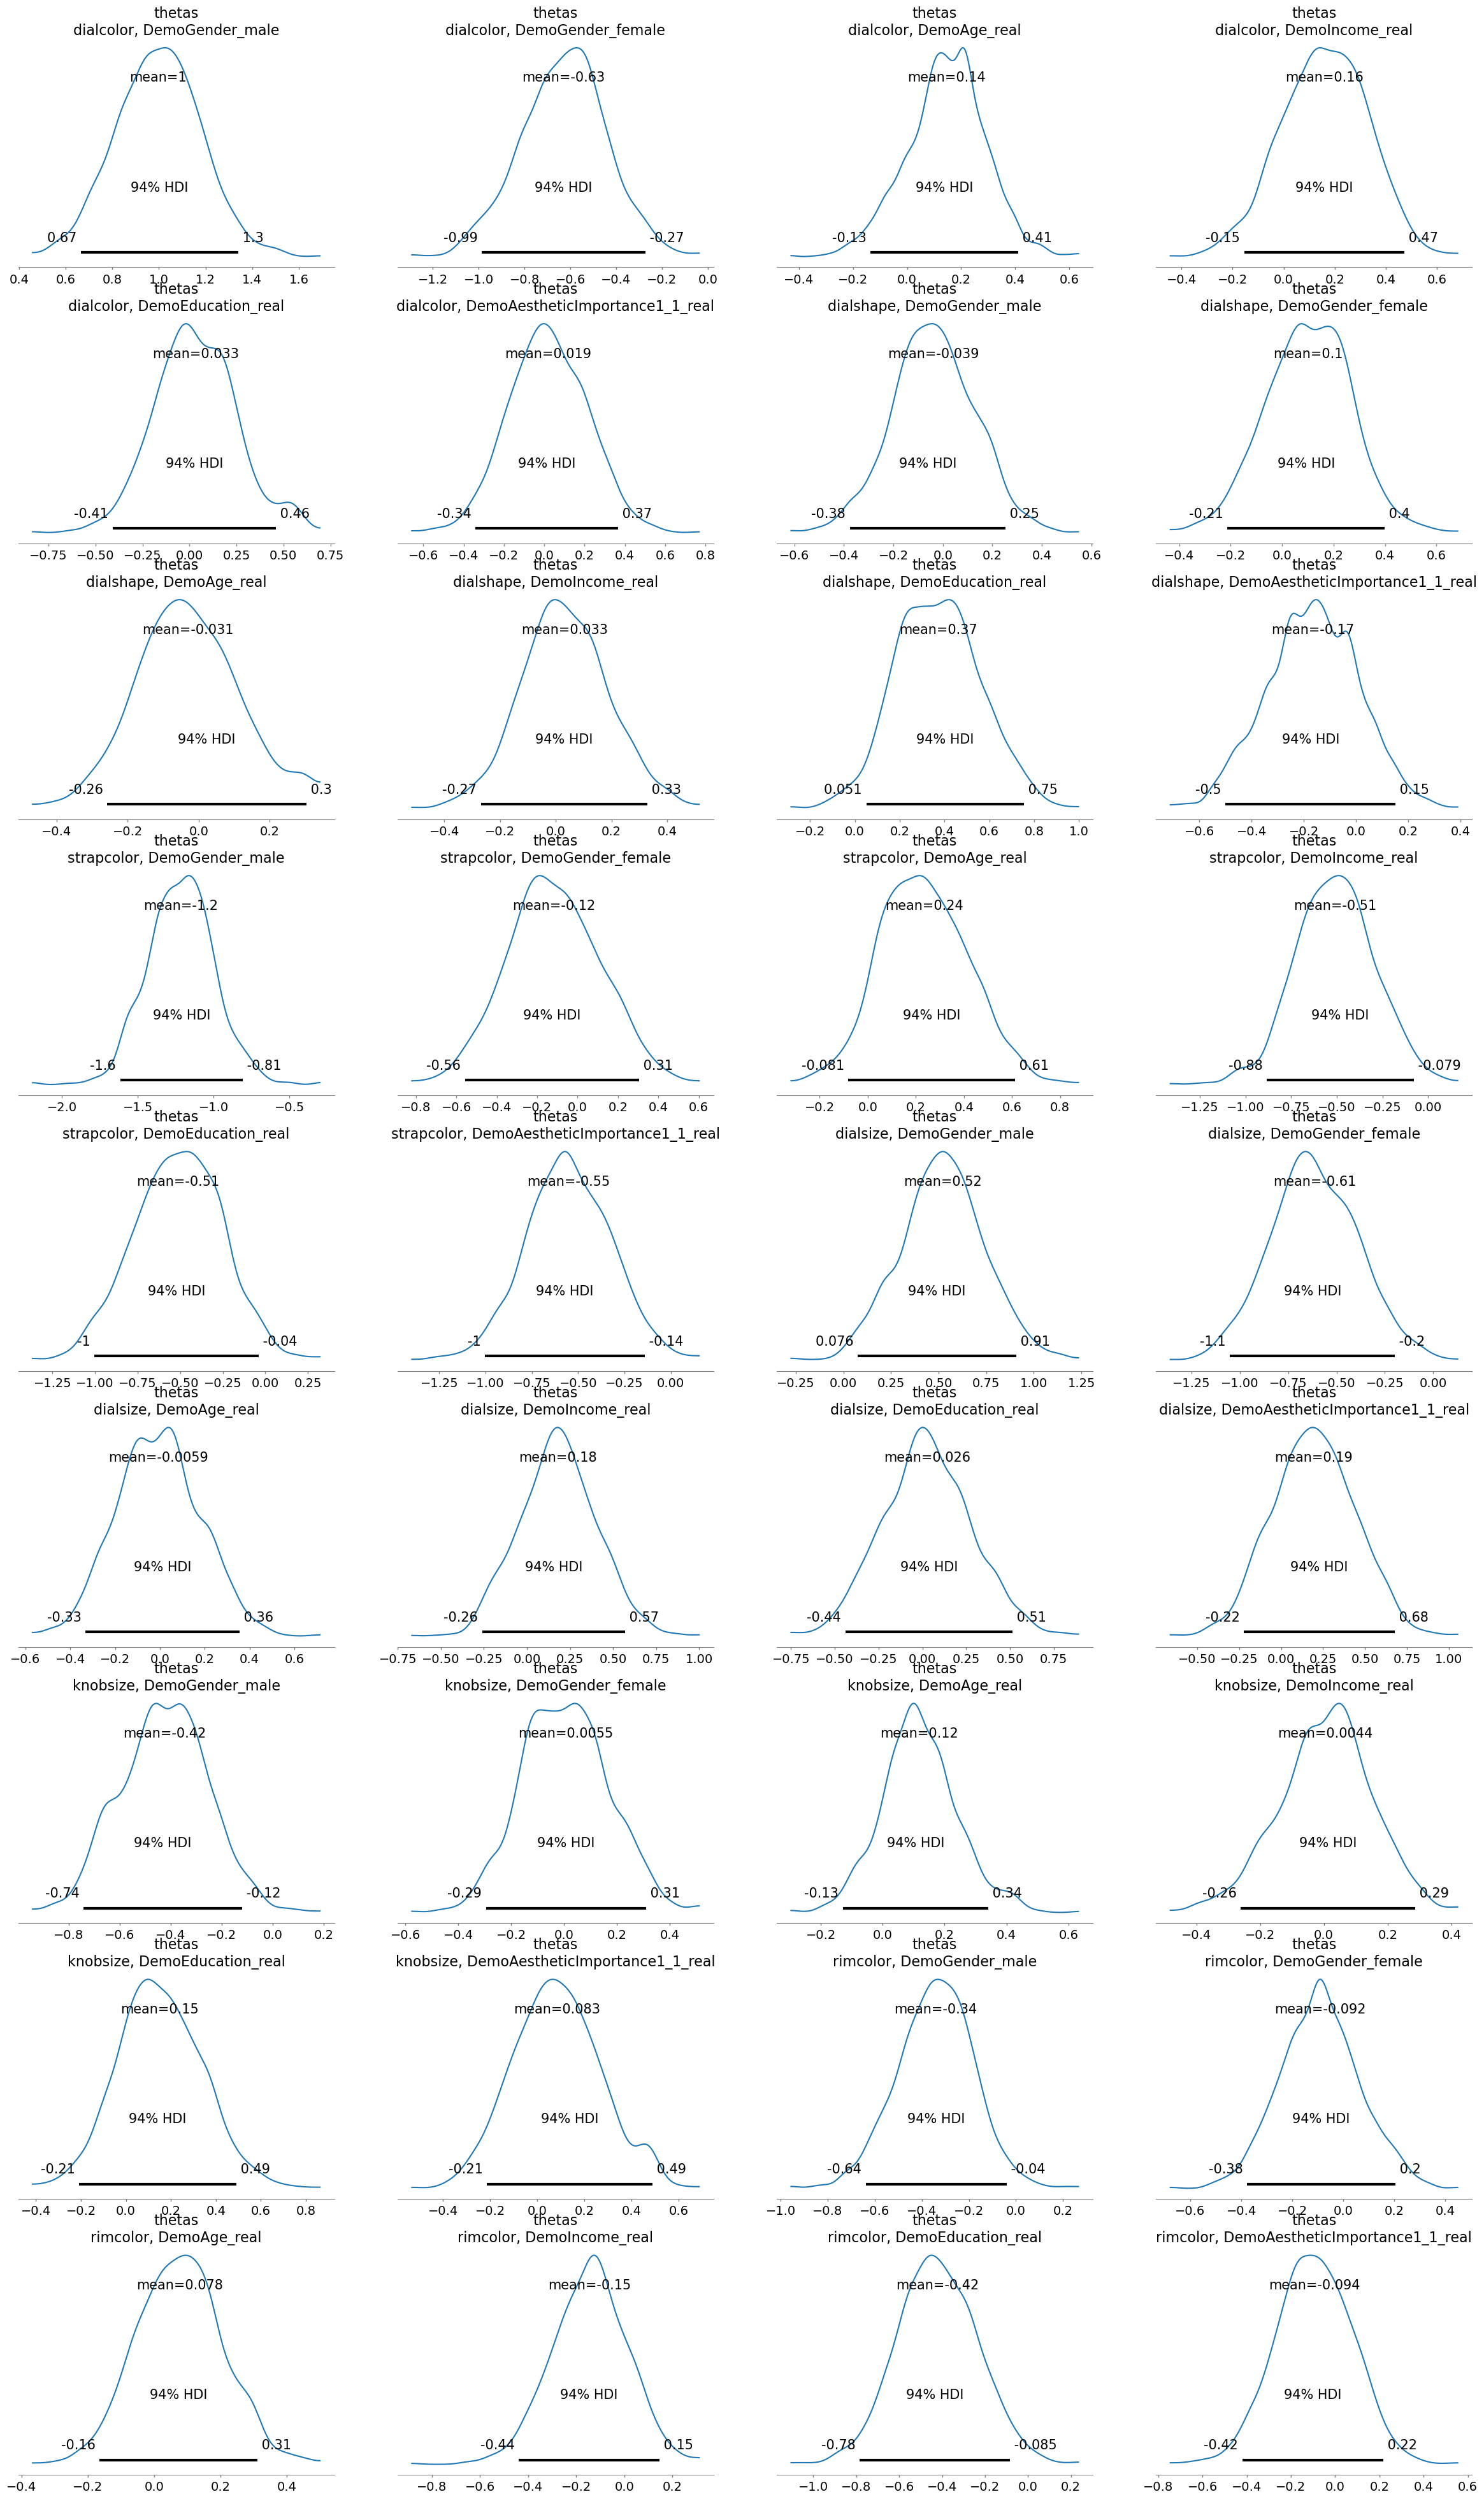

In [20]:
# Jan 9, 2024 Run (original final results run -- best Bayesian hyperparams/model setting for data)
pm.plot_posterior(idata_seg, var_names=["thetas"])

array([[<Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoGender_male'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoGender_female'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoAge_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoIncome_real'}>],
       [<Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoEducation_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialcolor, DemoAestheticImportance1_1_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoGender_male'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoGender_female'}>],
       [<Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoAge_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoIncome_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoEducation_real'}>,
        <Axes: title={'center': 'theta_mu_hyper\ndialshape, DemoAestheticImportance1_1_real'}>],
 

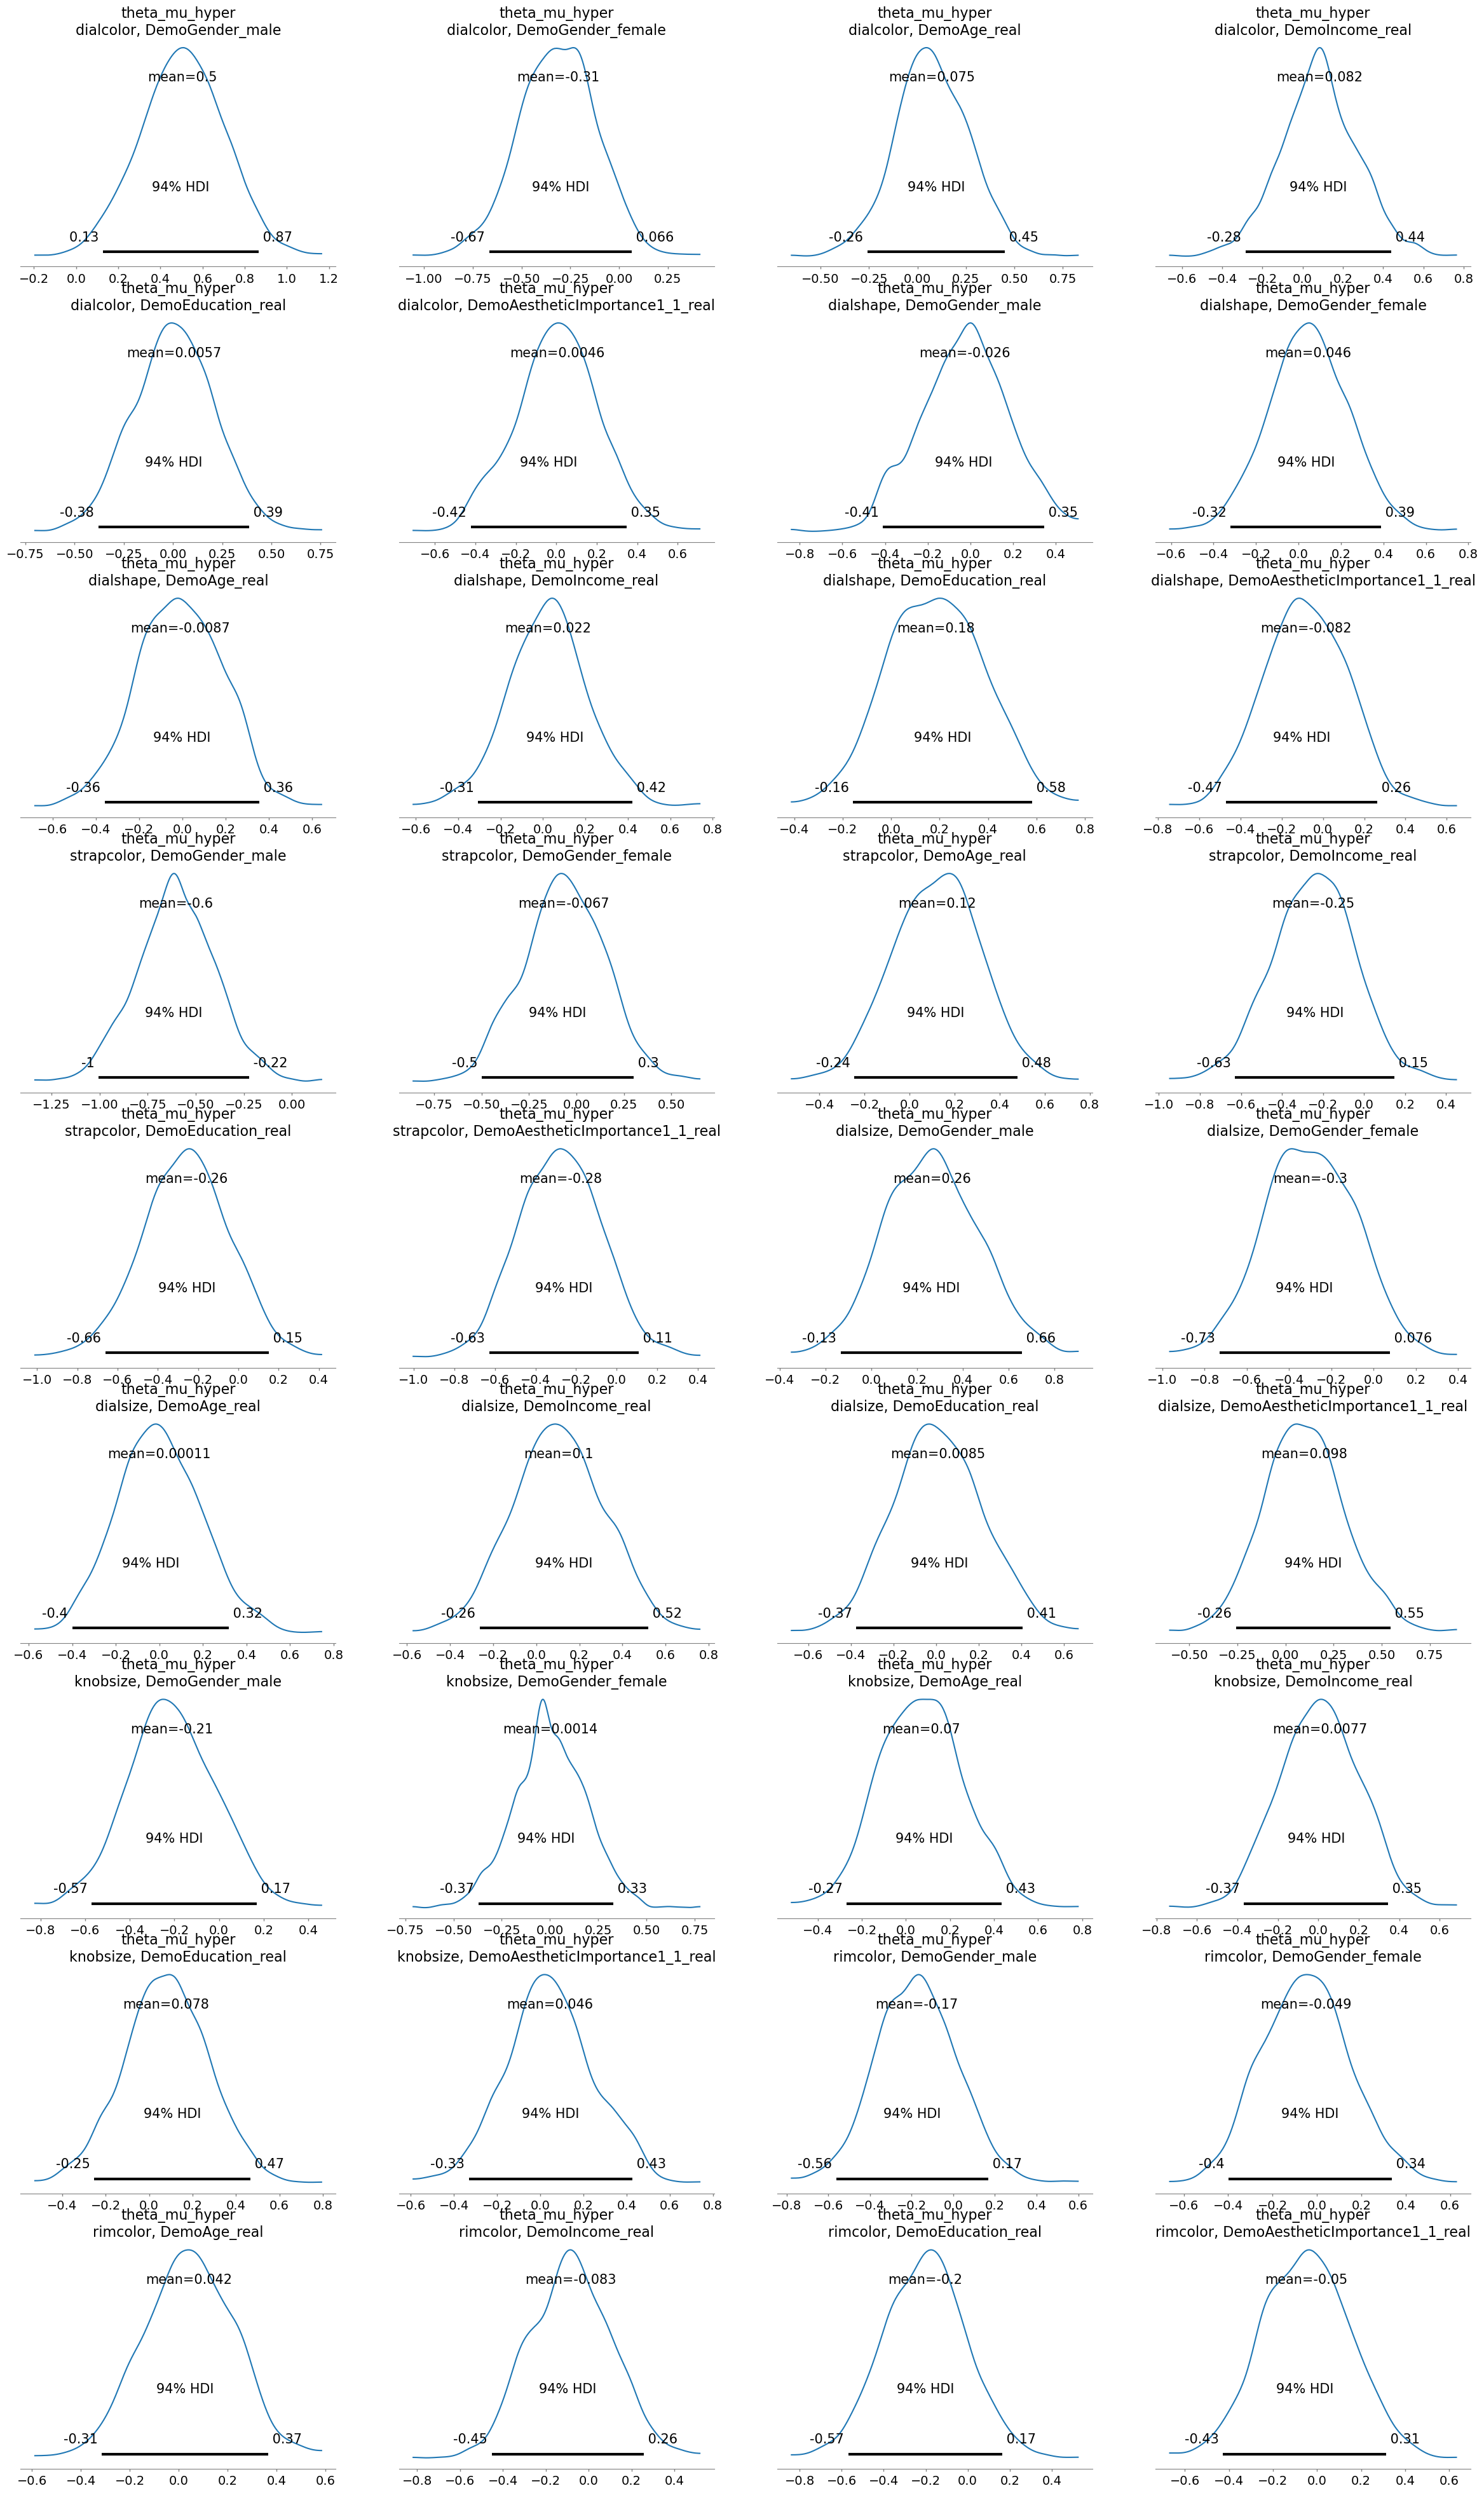

In [21]:
pm.plot_posterior(idata_seg, var_names=["theta_mu_hyper"])

# Beta and Theta Matrix - Plotting - Jan 9, 2024 run

In [22]:
theta_means = idata_seg.posterior["thetas"].mean(dim=["chain", "draw"]).to_numpy()
theta_mu_hyper_means = idata_seg.posterior["theta_mu_hyper"].mean(dim=["chain", "draw"]).to_numpy()

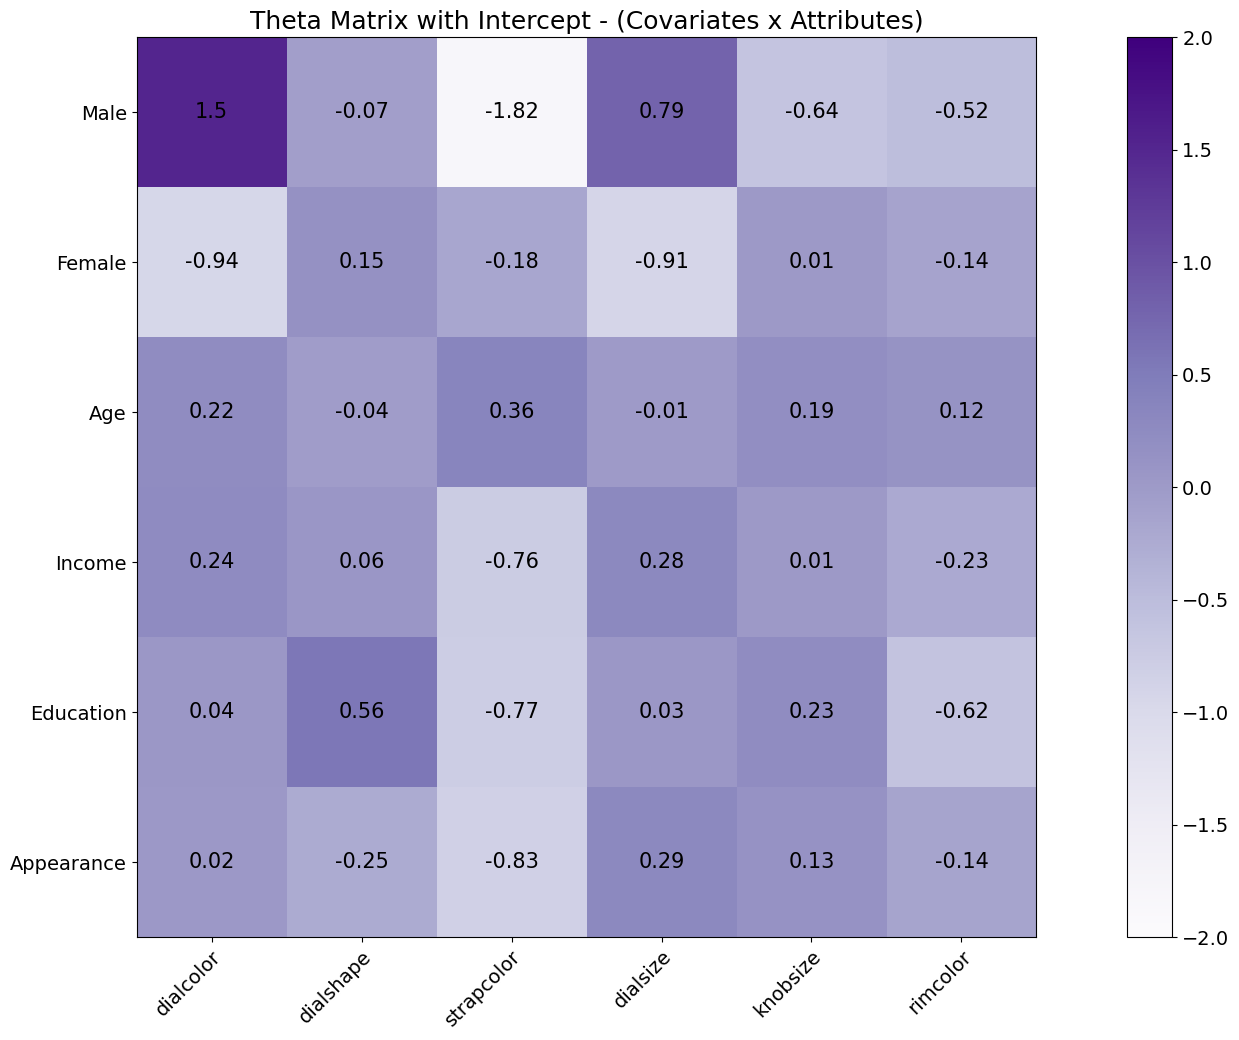

In [23]:
# Plot Theta Matrix Heatmap - Jan 9, 2024 run

COVARIATE_NAMES_SHORTER = ["Male", "Female", "Age", "Income", "Education", "Appearance"]



fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

theta_means_with_intercept = theta_means + theta_mu_hyper_means
im = ax.imshow(theta_means_with_intercept.T, cmap="Purples", vmin=-2.0, vmax=2.0)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(COVARIATE_NAMES)), labels=COVARIATE_NAMES_SHORTER, size=14)
ax.set_xticks(np.arange(len(VISUAL_ATTRIBUTE_NAMES)), labels=VISUAL_ATTRIBUTE_NAMES, size=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(VISUAL_ATTRIBUTE_NAMES)):
    for j in range(len(COVARIATE_NAMES)):
        text = ax.text(i, j, theta_means_with_intercept[i, j].round(2),
                       ha="center", va="center", color="black", size=15)


cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=14)

ax.set_title("Theta Matrix with Intercept - (Covariates x Attributes)", size=18)
fig.tight_layout()
plt.show()

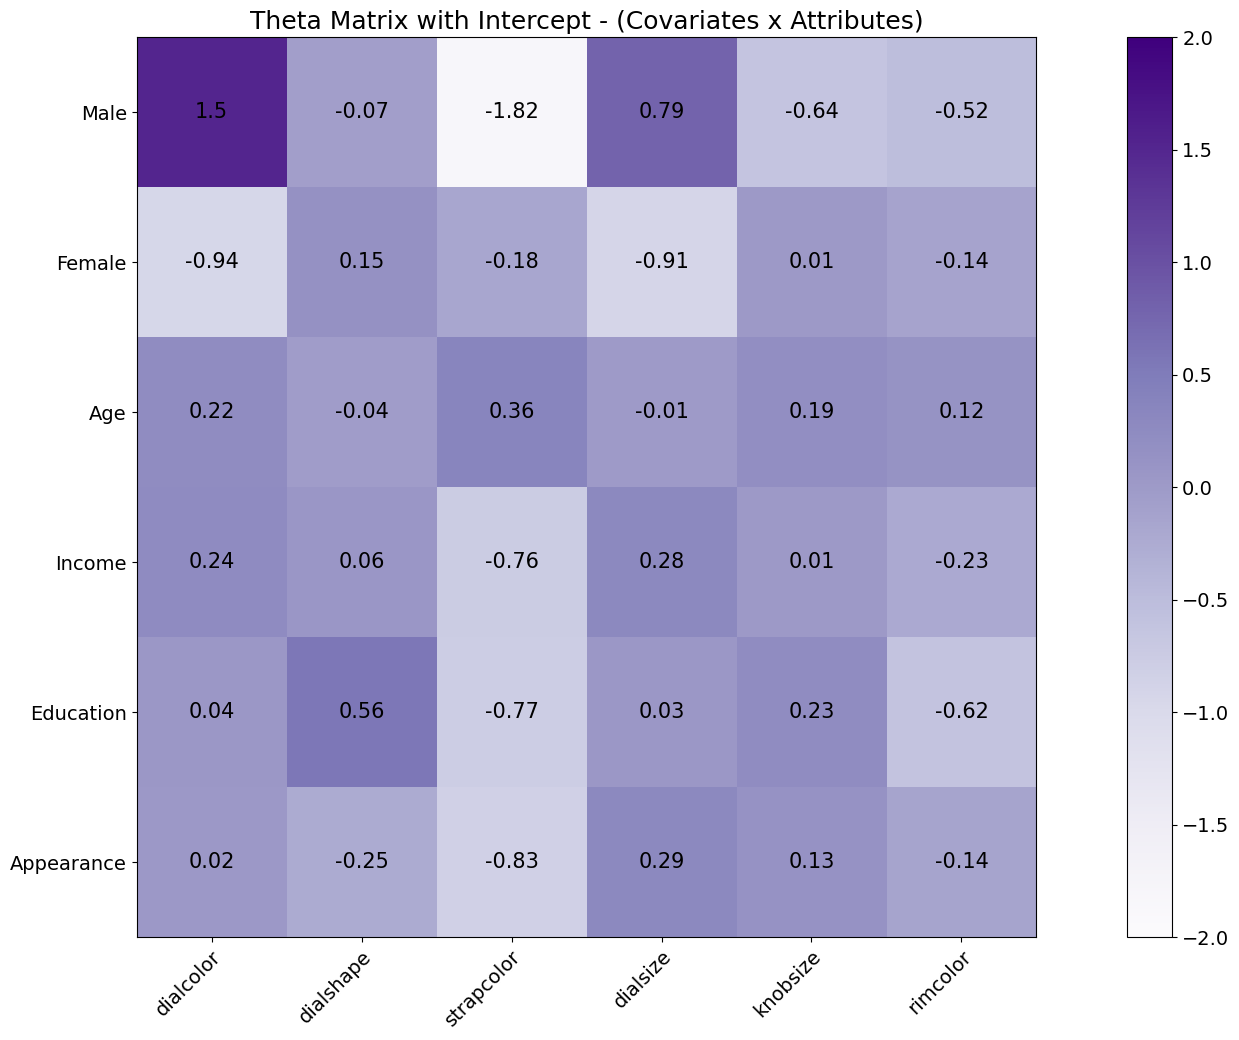

In [24]:
# Plot Theta Matrix Heatmap - Jan 9, 2024 run

COVARIATE_NAMES_SHORTER = ["Male", "Female", "Age", "Income", "Education", "Appearance"]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

theta_means_with_intercept = theta_means + theta_mu_hyper_means
im = ax.imshow(theta_means_with_intercept.T, cmap="Purples", vmin=-2.0, vmax=2.0)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(COVARIATE_NAMES)), labels=COVARIATE_NAMES_SHORTER, size=14)
ax.set_xticks(np.arange(len(VISUAL_ATTRIBUTE_NAMES)), labels=VISUAL_ATTRIBUTE_NAMES, size=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(VISUAL_ATTRIBUTE_NAMES)):
    for j in range(len(COVARIATE_NAMES)):
        text = ax.text(i, j, theta_means_with_intercept[i, j].round(2),
                       ha="center", va="center", color="black", size=15)


cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=14)

ax.set_title("Theta Matrix with Intercept - (Covariates x Attributes)", size=18)
fig.tight_layout()
plt.show()

# Ideal Point Choice Share - Jan 9, 2024 (cond accept revision)
## How to do and assumptions

* First, take a frequentist approach by calculating mean of beta posterior per individual and theta matrix posteriors for population


In [28]:
theta_means = idata_seg.posterior["thetas"].mean(dim=["chain", "draw"]).to_numpy()
theta_mu_hyper_means = idata_seg.posterior["theta_mu_hyper"].mean(dim=["chain", "draw"]).to_numpy()
beta_mu_means = idata_seg.posterior["betas"].mean(dim=["chain", "draw"]).to_numpy()
theta_means_with_intercept = theta_means + theta_mu_hyper_means

In [29]:
# Remind myself what I did months ago...
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, Z_df.shape

((253, 13, 2, 6), (253, 2, 2, 6), (253, 13), (253, 2), (253, 6))

## Manually defining segments (as per review update) - Theta matrix suggests "sex" and "income"

In [30]:
# High income women - maps to ~ > $100,000 given scaling in conjoint question
Z_seg_highInc_women = Z_df[(Z_df["DemoIncome_real"] >= 0.5) & (Z_df["DemoGender_male"] == 0.0)]

# Low income men - maps to ~ < $50,000 given scaling in conjoint question
Z_seg_lowInc_men = Z_df[(Z_df["DemoIncome_real"] <= -0.25) & (Z_df["DemoGender_male"] == 1.0)]

## Calc Betas

In [31]:
betas_seg_highInc_women = np.dot(theta_means_with_intercept, Z_seg_highInc_women.to_numpy().T).T
betas_seg_lowInc_men = np.dot(theta_means_with_intercept, Z_seg_lowInc_men.to_numpy().T).T

## Get all existing generated designs, find uniques in X_train

In [32]:
X_existing = np.unique(X_train.reshape(253*13*2, 6), axis=0)
X_existing

array([[-1.67869   , -1.20223   , -1.8142042 , -1.1301345 , -1.441934  ,
        -1.200353  ],
       [-1.67869   , -1.20223   , -1.8142042 , -1.1301345 , -1.441934  ,
         0.26284418],
       [-1.67869   , -1.20223   , -1.8142042 , -1.1301345 , -1.441934  ,
         1.934439  ],
       ...,
       [ 1.1777715 ,  1.53898   ,  1.0799969 ,  0.7543965 ,  1.316403  ,
        -1.200353  ],
       [ 1.1777715 ,  1.53898   ,  1.0799969 ,  0.7543965 ,  1.316403  ,
         0.26284418],
       [ 1.1777715 ,  1.53898   ,  1.0799969 ,  0.7543965 ,  1.316403  ,
         1.934439  ]])

In [33]:
seg_one_betas = betas_seg_highInc_women
seg_two_betas = betas_seg_lowInc_men

seg_one_betas_repeated = np.repeat(betas_seg_highInc_women[:, :, None], 728, axis=2).swapaxes(1,2)
seg_two_betas_repeated = np.repeat(betas_seg_lowInc_men[:, :, None], 728, axis=2).swapaxes(1,2)

In [34]:
utilties_seg_one_existing = (seg_one_betas_repeated * X_existing).sum(axis=2)
utilties_seg_two_existing = (seg_two_betas_repeated * X_existing).sum(axis=2)

In [35]:
utilties_seg_one_existing_indices_sorted = np.argsort(utilties_seg_one_existing, axis=1)[:, ::-1]
utilties_seg_two_existing_indices_sorted = np.argsort(utilties_seg_two_existing, axis=1)[:, ::-1]

## FINAL RESULTS - Jan. 9, 2024 - review update to manually defined segments - get cluster-level EXISTING MARKET TOP-10 PRODUCTS 

In [36]:
# Get the most frequent Top-10 utilties for each individual consumer's segment membership preference, and use this as population-level top 10 for segment
# Why? Individual-level HB estimation of *distributions* -> frequentist assumption of aggregated *point estimate* means

top_utility_indices_seg1_existing, top_utility_counts_seg1_existing = np.unique(utilties_seg_one_existing_indices_sorted[:, :10].ravel(), return_counts=True)
top_utility_indices_seg2_existing, top_utility_counts_seg2_existing = np.unique(utilties_seg_two_existing_indices_sorted[:, :10].ravel(), return_counts=True)

### Seg 1

In [37]:
top_utility_indices_seg1_existing, top_utility_counts_seg1_existing

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  15,
         16,  29,  81,  82,  83,  84,  87,  88,  90,  96, 108, 162, 163,
        164, 165, 168, 169, 171, 174, 177, 186, 189, 190, 191, 192, 195,
        196, 222, 249, 330, 405, 408, 411, 420]),
 array([ 6,  3,  1,  4,  3,  1, 16,  3,  1,  2,  1,  1,  2,  1,  1, 15,  2,
         1, 28, 34,  2,  4, 15,  1, 24,  1,  1, 34, 33,  5, 14, 22, 29, 13,
         1,  1,  1,  1,  8,  1,  1,  1,  5,  1,  2, 18,  5]))

In [38]:
np.sort(top_utility_counts_seg1_existing)[::-1]

array([34, 34, 33, 29, 28, 24, 22, 18, 16, 15, 15, 14, 13,  8,  6,  5,  5,
        5,  4,  4,  3,  3,  3,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [39]:
top_10_utility_indices_seg1_existing = top_utility_indices_seg1_existing[np.argsort(top_utility_counts_seg1_existing)[::-1]][:10]
top_10_utility_indices_seg1_existing

array([ 87, 165, 168, 177,  84, 162, 174, 411,   6,  81])

### Seg 2

In [40]:
top_utility_indices_seg2_existing, top_utility_counts_seg2_existing

(array([495, 496, 497, 504, 505, 506, 507, 508, 531, 576, 585, 586, 587,
        588, 648, 657, 660, 666, 667, 669, 672]),
 array([33, 16,  4, 34, 27, 19, 29,  6, 21, 17, 34, 23,  1, 14,  1, 14,  1,
        26,  7, 12,  1]))

In [41]:
top_10_utility_indices_seg2_existing = top_utility_indices_seg2_existing[np.argsort(top_utility_counts_seg2_existing)[::-1]][:10]
top_10_utility_indices_seg2_existing

array([585, 504, 495, 507, 505, 666, 586, 531, 506, 576])

array([585, 504, 495, 507, 505, 666, 586, 531, 506, 576])

# Define optimal product for segments by scaling beta segment with norm of generated watches in top 10 FOR FULL MARKET NOW (Jan 9, 2024 change)

### Unscaled ideal products from beta preferences of segments

In [42]:
ideal_product_seg1_unscaled = seg_one_betas.mean(axis=0)
ideal_product_seg2_unscaled = seg_two_betas.mean(axis=0)

In [43]:
seg1_betas_norm = np.linalg.norm(ideal_product_seg1_unscaled, axis=0)
seg2_betas_norm = np.linalg.norm(ideal_product_seg2_unscaled, axis=0)

### Average Euclidean Norm of existing market (top 10 consideration set of segment)

In [44]:
norm_scaling_gen_watches_seg1 = np.linalg.norm(X_existing[top_10_utility_indices_seg1_existing, :], axis=1).mean(axis=0)
norm_scaling_gen_watches_seg1

3.34621747926865

In [45]:
norm_scaling_gen_watches_seg2 = np.linalg.norm(X_existing[top_10_utility_indices_seg2_existing, :], axis=1).mean(axis=0)
norm_scaling_gen_watches_seg2

3.049938439779041

## "Ideal Point" Optimal Products Defined

In [46]:
optimal_product_seg1 = (norm_scaling_gen_watches_seg1 / seg1_betas_norm) * ideal_product_seg1_unscaled
optimal_product_seg2 = (norm_scaling_gen_watches_seg2 / seg2_betas_norm) * ideal_product_seg2_unscaled

optimal_product_seg1, optimal_product_seg2

(array([-1.24844506,  0.43979155, -2.73047975, -0.85085437,  0.23906322,
        -1.09932512]),
 array([ 1.36865903, -0.30892671, -2.34501305,  0.90977291, -0.83355017,
        -0.55846434]))

## Define New market - Add in ideal product utility to existing market of products

In [47]:
utilties_seg_one_existing_top10 = utilties_seg_one_existing[:, top_10_utility_indices_seg1_existing]
utilties_seg_two_existing_top10 = utilties_seg_two_existing[:, top_10_utility_indices_seg2_existing]
utilties_seg_one_existing_top10.shape, utilties_seg_two_existing_top10.shape

((37, 10), (34, 10))

In [48]:
new_product_utility_seg1 = np.expand_dims((seg_one_betas * optimal_product_seg1).sum(axis=1), 1)
new_product_utility_seg2 = np.expand_dims((seg_two_betas * optimal_product_seg2).sum(axis=1), 1)

new_product_utility_seg1.shape, new_product_utility_seg2.shape

((37, 1), (34, 1))

In [49]:
utilties_seg1_existing_and_new = np.concatenate([new_product_utility_seg1, utilties_seg_one_existing_top10], axis=1)
utilties_seg2_existing_and_new = np.concatenate([new_product_utility_seg2, utilties_seg_two_existing_top10], axis=1)

## Calculate Choice Shares of Segments in New Market

In [50]:
def softmax_matrix(logits, sum_over_matrix=True):
    """Compute softmax values for each logit.
    Expects a numpy array

    This works same as typical softmax that does not subtract the max, mathematically equivalent, but this is better for numerical stability
    """
    max_val = np.max(logits, axis=1, keepdims=True)
    e_x = np.exp(logits - max_val)
#     denominator = np.sum(e_x, axis=-1, keepdims=True)
    
    return e_x / np.sum(e_x, axis=1, keepdims=True) # only difference


In [51]:
choice_shares_seg1_existing_and_new = softmax_matrix(utilties_seg1_existing_and_new)
choice_shares_seg2_existing_and_new = softmax_matrix(utilties_seg2_existing_and_new)

choice_shares_seg1_existing_and_new.shape, choice_shares_seg2_existing_and_new.shape

((37, 11), (34, 11))

In [52]:
choice_shares_seg1_existing_and_new[:, 0].mean(), choice_shares_seg2_existing_and_new[:, 0].mean()

(0.20870922049038745, 0.24774180418144176)

# Re-doing Choice Share Plot - Feb. 2, 2024 (update colors for grayscaling for publishing + check replicability)

In [53]:
choice_shares_seg1_existing = softmax_matrix(utilties_seg_one_existing_top10)
choice_shares_seg2_existing = softmax_matrix(utilties_seg_two_existing_top10)

In [54]:
np.hstack((0,choice_shares_seg1_existing.mean(axis=0)))

array([0.        , 0.11053687, 0.12256977, 0.1528283 , 0.09766899,
       0.09071947, 0.1080348 , 0.07738286, 0.07815643, 0.07949516,
       0.08260735])

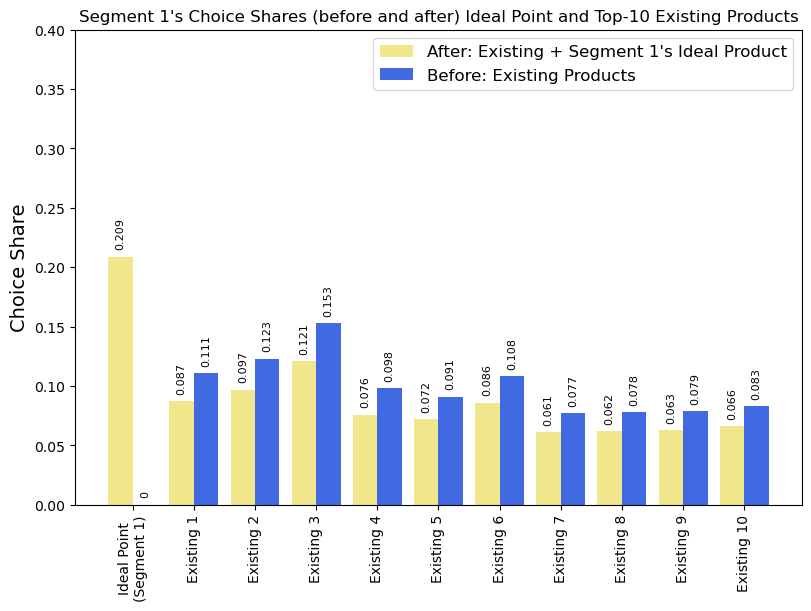

In [58]:
# National football champs this year
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['khaki','royalblue'])

product_names = ("Ideal Point\n(Segment 1)", "Existing 1", "Existing 2", "Existing 3", "Existing 4","Existing 5", "Existing 6","Existing 7","Existing 8", "Existing 9", "Existing 10")
product_shares = {
    'After: Existing + Segment 1\'s Ideal Product': choice_shares_seg1_existing_and_new.mean(axis=0).round(3),
    'Before: Existing Products': np.hstack((0,choice_shares_seg1_existing.mean(axis=0))).round(3),
}

x = np.arange(len(product_names))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(8, 6)

for attribute, measurement in product_shares.items():
    offset = width * multiplier
    if multiplier % 2 == 0:
        cur_hatch = ['']
    else:
        cur_hatch = ['']
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=cur_hatch)
    ax.bar_label(rects, padding=5,  rotation=90, fontsize=8)
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Choice Share', size=14)
ax.set_title('Segment 1\'s Choice Shares (before and after) Ideal Point and Top-10 Existing Products', size=12)
ax.set_xticks(x + width/2, product_names)
plt.xticks(rotation=90)
ax.legend(loc='upper right', ncols=1, prop={'size': 12})
ax.set_ylim(0, 0.4)

plt.show()

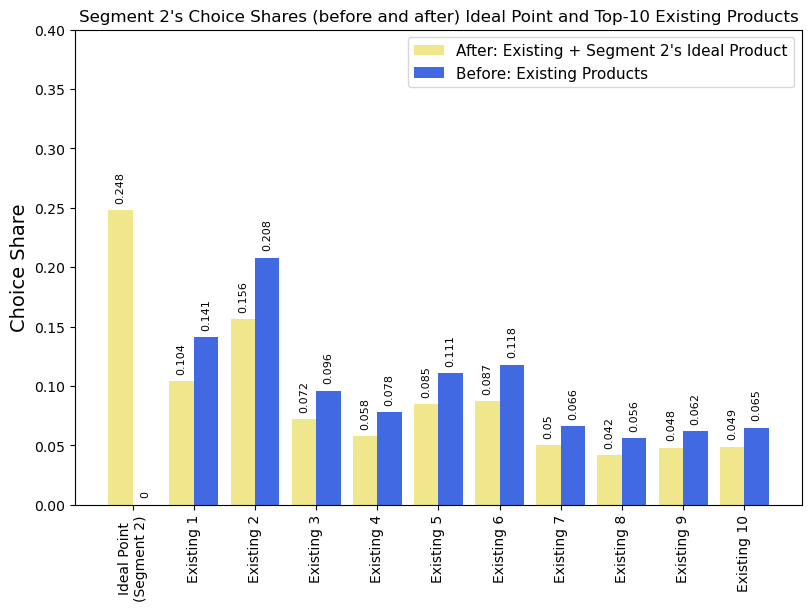

In [59]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['khaki','royalblue'])

product_names = ("Ideal Point\n(Segment 2)", "Existing 1", "Existing 2", "Existing 3", "Existing 4","Existing 5", "Existing 6","Existing 7","Existing 8", "Existing 9", "Existing 10")
product_shares = {
    'After: Existing + Segment 2\'s Ideal Product': choice_shares_seg2_existing_and_new.mean(axis=0).round(3),
    'Before: Existing Products': np.hstack((0,choice_shares_seg2_existing.mean(axis=0))).round(3),
}

x = np.arange(len(product_names))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_size_inches(8, 6)

for attribute, measurement in product_shares.items():
    offset = width * multiplier
    if multiplier % 2 == 0:
        cur_hatch = ['']
    else:
        cur_hatch = ['']
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=cur_hatch)
    ax.bar_label(rects, padding=5,  rotation=90, fontsize=8)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Choice Share', size=14)
ax.set_title('Segment 2\'s Choice Shares (before and after) Ideal Point and Top-10 Existing Products', size=12)
ax.set_xticks(x + width/2, product_names)
plt.xticks(rotation=90)
ax.legend(loc='upper right', ncols=1, prop={'size': 11})
ax.set_ylim(0, 0.4)

plt.show()
